# Lab 3: Building a Photometric Pipeline

In this lab, we'll be using classes and functions to build a pipeline which will automatically extract the fluxes of stars in an image. We're all familiar with aperture photometry, but in this case, we're going to take the additional step of convolving our image with a PSF. 

Our pipeline will be split into several steps. 

1. Reading in an image 
2. Finding the local peaks in the image (the stars)
3. Calculating the centroid of each peak region 
4. Convolving with the PSF and extracting flux. 



## Problem 1

Read in the image `2020-04-15-0001.fits` and plot it, using your handy functions from Lab 2. This image was taken of the M81/M82 field using the Dragonfly Telephoto Array (in a narrowband configuration). 

In [48]:
# Your solution

## Problem 2

Our goal is to estimate the PSF of the above image, then measure fluxes of the stars and galaxies here accounting for the PSF. 

To start this process, we need to locate the stars in this image. We saw how to segment an image using `sep` last time, but in this lab we are going to carry out this step ourselves, using two methods. 

### Problem 2.1

Before we do this, we want to take the step of masking out several regions of the image which may register as peaks but which are not nicely isolated stars. In particular, the two galaxies, and the two optical artifacts (actually, detector amp glow) in the bottom center and bottom left of the image. 

By querying the image dimensions, construct a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html) which masks out rough patches over these regions we want to avoid. Plot your masked array to demonstrate the appropriate regions have been masked out.

In [420]:
# Solution
mask = ...

### Problem 2.2

Now that we have the appropriate image regions masked, we can move on to the peak finder. 

The "fast" or "efficient" method of doing this involves some scipy filtering operations. But for our purposes, the "slow way" (iterating over the image pixels) takes ~few seconds to run, and is worth doing to build intuition. 

Complete the function below to find peaks in an image by looping over each pixel and checking its neighbors, with a "peak" being defined as a region of higher flux than all adjacent pixels (i.e., the 8 surrounding pixels). In order to not pick up random noise pixels, also take an input called `threshold`. Within your algorithm, don't return any pixels which are "peaks" but for which the pixel value is below this threshold. 

```{hint}
:dropdown: 
This algorithm needs to avoid the edges of the image (since indexing "i+1" won't work there). 
```

In [70]:
# Solution
def find_peaks(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    '''
    #Your code here
    return 

The looping solution is slow, and will not scale well if we have to run on many images, but for one image is okay. 

There are several solutions which generally involve either **filtering** the image or **cross correlating** the image with a template. Here's one such solution --- you'll note that it runs much faster than the standard looping method you used above.

In [399]:
from scipy.ndimage import maximum_filter

def findpeaks_maxfilter(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    
    Parameters
    ----------
    image: array_like
        2D array containing the image of interest.
    threshold: float
        minimum pixel value for inclusion in search
    
    Returns
    -------
    peaks: array_like
        array containing the x and y coordinates of peak regions.
    '''
    neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
    # find local maximum for each pixel
    amax = maximum_filter(image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.
    
    peaks = np.where((image == amax) & (image >= threshold)) #find the pixels unaffected by the max filter.
    peaks = np.array([peaks[0],peaks[1]]).T
    return peaks

Let's take a moment to understand how this algorithm works. The key is in the `maximum_filter()` step. Filtering a 2D image is a process carried out in fourier space, which is what allows scipy to carry it out quickly. But what is maximum filtering?

```{admonition} Definition
Maximum Filtering is the process by which all pixels in local neighborhoods within an array are raised to the maximum value of any pixel in that neighborhood
```

Let's look at a 1D case. Below, I define a 1D array that has some peaks in it. 

In [110]:
array_1dpeaks = np.array([1,1,2,1,2,1,2,1,2,3,4,3,2,1,2,4,5,6,8,6,5,4,3,2,4,3,4,2,1,0.5,1,2,1,2,3,2])

Our data looks like this:

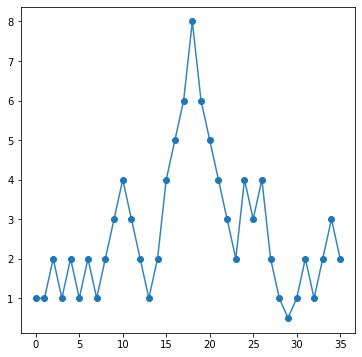

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9)
ax.plot(array_1dpeaks,'o',color='C0')

Let's now run the maximum filter on this data and plot it's output. I'm going to pick a neighborhood of 3, which means +/- 1 pixel around each location.

In [112]:
mf = maximum_filter(array_1dpeaks, footprint=np.ones(3,dtype=bool)) 

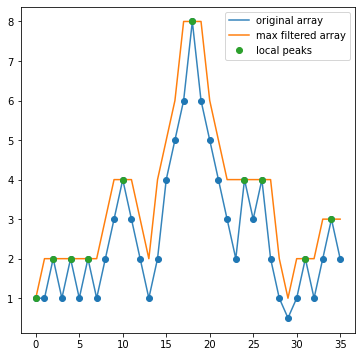

In [120]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9,label='original array')
ax.plot(array_1dpeaks,'o',color='C0')
ax.plot(mf,label='max filtered array')
eq, = np.where(array_1dpeaks==mf)
ax.plot(np.arange(len(mf))[eq],mf[eq],'o',label='local peaks')
ax.legend();

What the filtering has done is for every 3 pixel neighborhood across this array, it's raised the value of all three pixels to the maximum value across the three. So we see that anywhere the three pixels were, e.g., (1,2,1), they are all now 2. What you should notice looking at this plot is that the max filtering has also identified true peaks in our data! Notice that the only spots where the orange curve (the max filtered version of the data) is equal to the original array is exactly at locations that are local maxima. This is because when applying max filtering to an array, the only values *unchanged* by the filtering are those that *are* local maxima (in the neighborhood defined). 

And thus, we have our peaks! All we need to do is find out `where()` the max filtered array equals the original array (pixel by pixel). Of course, we can also put in a threshold (like above, maybe 2.5) to ensure low level noise doesn't enter in. This is why the `findpeaks_maxfilter()` function has a threshold option as well.

```{note}
You may notice that the first index in the array is marked as a peak, despite not being one. Edges are always troublesome with these algorithms, and they normally have multiple options for how edges are handled. 
```


## Problem 2.3 

For the remainder of this assignment, you can use either your peak finder, or the faster one provided. But before you decide, as a quick check, use the `%%timeit` magic command in your notebook to test how fast the two algorithms are respectively. If you were working with a sample of 1000 images, how long would the looping algorithm take compared to the max-filtering case?

In [ ]:
%%timeit
# your code here

In [ ]:
%%timeit
# your code here

In [ ]:
# how long for 1000 images with each function?

### Problem 2.4 

Run your peakfinder on your masked image, and assemble the list of peaks you'll use moving forward. I suggest using $3\sigma$ above the mean image value as a solid threshold.


Plot up the original image, but use our "source circling" technique from last lab to circle all the peaks found in the masked image. I show mine below.

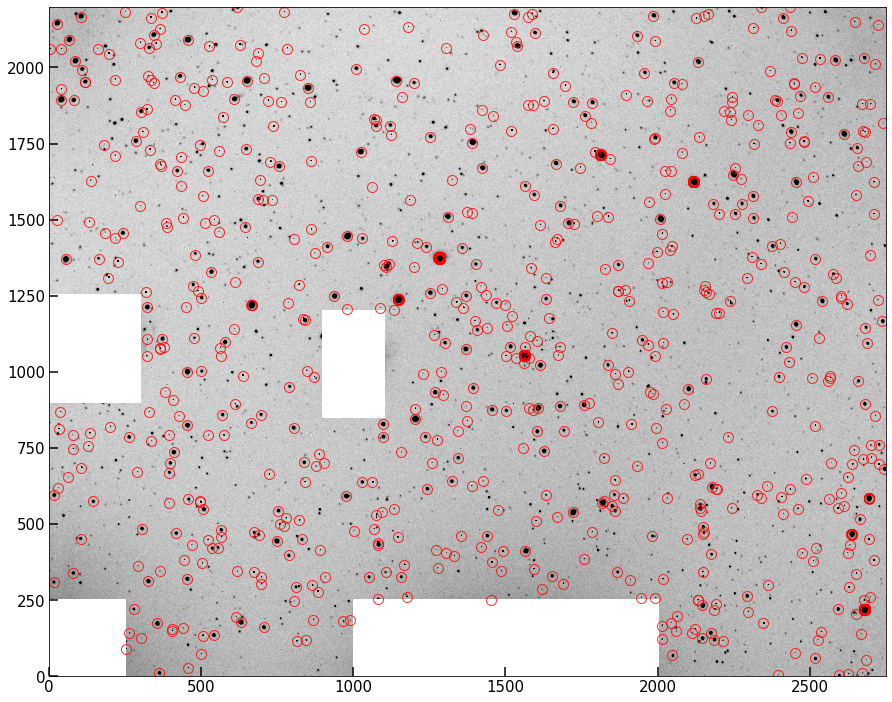

In [400]:
#My peaks below

### Problem 2.5 

This should look pretty good -- most of what's circled above is clearly a star/point source in the image. However, one problem with this method is that single hot pixels are going to be registered as peaks, even via the more clever algorithm. We need a way to eliminate these from our sample before moving on. 

Copy down your peak-finder and add in something that checks that not only is there a true peak, but that at least 4 of the pixels around the peak are also elevated in flux (I used 0.5 times the peak flux). The easiest way is to loop over the peaks after they're found and institute the check --- there are far fewer peaks than pixels, so this doesn't significantly affect the runtime. But feel free to find a cleverer solution!

```{warning}
Be careful with transpositions in this problem. when you plot coordinates, you plot(x,y), but when you index the image, you index image[y,x]. Be tracking which is which! As a note, the original output of `findpeaks_maxfilter()`, peaks, was of the form [ array([y1,y2,y3,...]),array([x1,x2,x3,...])].
```

In [401]:
def findpeaks_maxfilter(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    '''
    # add in check against single pixel peaks
    return ...

Re-find your peaks using your newer, better algorithm, and plot them below as before.

You should notice that we've decreased our total number of peaks. But you should find that now, everything currently circled looks like a bright, "resolved" star. (resolved insofar as the PSF is spreading the light of the star over multiple pixels). 

### Problem 2.6 

In your the image above, you should see that ~8-10 stars look like they are circled by several very closely overlapping circles all targeting the same star. Infer (or investigate and determine) why this has happened, and write your answer below. 




*answer here*

## Problem 3 

We now have a function that can return the peaks in a given image. Our next step is going to be to estimate the exact center of those peaks (stars) using their **centroid**.

```{admonition} Definition
The centroid is the light-weighted-mean of a set of pixels. It is not always the maximum-valued pixel, and is determined to sub-pixel accuracy.
```

Many of you have seen the centroid formula, but as a reminder, it looks like this (in 1D):


$$
x_{\rm com} = \frac{\sum{x_i F_i}}{\sum F_i},
$$
where $x_i$ are the positions and $F_i$ are the fluxes at those positions. 

In 2D, when working with images, the $x$ and $y$ centers of mass are independent, and the 2D centroid is just the location ($x_{\rm com}$, $y_{\rm com}$). 

### Problem 3.1 

Finish the function below, which should read in an image and a peak location returned by your peak finder, then create a window of NxN pixels around it (user-settable), and determine the centroid of this window. The $x,y$ locations of this centroids should be returned.

One subtlety --- We want to use a window size greater than 1 pixel on either side of each peak. But because our peak finder is likely to find peaks near the edge of the detector (both because it needs only 1 pixel-thick borders and because it handles edges), if we write a centroid function that, e.g., uses a 10x10 pixel window, we'll end up trying to index over the edge of the original image. Because of this, your function should raise an exception if a peak position is entered whose distance from an edge is less than half the window size. 

In [364]:
# Solution 
def centroid_peak(image,peak_x,peak_y,window=10):
    '''
    Given an image and list of peak positions, determine the centroid in the region of each peak.
    FINISH DOCSTRING
    '''
    # Your code 
    return x_center, y_center
        

### Problem 3.2 
Use your `centroid_peak` function to confirm that the algorithm is working by testing it on a few individual peaks from your peak list, and make a plot showing the window region and the determined centroid (along with the location of the input peak). I'm leaving behind a demo of what I mean below. The blue point is the pixel with the peak flux, while the crosshairs center on the determined centroid

```{note}
It's ok if the centroid is not at what appears to be the center of the light distribution of the star. Often due to seeing and detector effects, along with tricks of the stretch you happen to be using, the centroid doesn't look perfectly centered.
```


(1.0, 21.0)

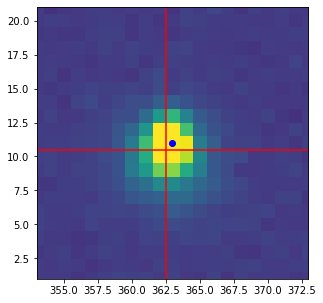

In [371]:
# Example below

### Problem 3.3

Now do this for all peaks in your image. You may need to use `try` and `except` blocks to skip any peaks that raise errors in your centroid code for being too close to the edge. I'll leave it to your discration whether you handle this by dropping that peak from the list and moving on, or by trying a smaller window first. (The second requires a bit more boiler plate but would allow you to retain a larger selection of stars).

In [ ]:
# centroid all peaks

### Problem 3.4 

If you recall from above, you determined why the peak algorithm occasionally marked a bunch of pixels as peaks within the same star, which shouldn't happen. It should be clear from your answer that these stars will be unusable for the purposes of measuring the PSF of stars in the image. We thus need to remove these ~8-10 stars from our sample. 

Write a function which takes in the list of centroids, and identifies these cases. The easiest way to do this is to simply iterate through the list of centroids and compute the distance to all other centroids in the list. Any centroid which has another centroid very nearby (within, say, 5 pixels) should be removed from our sample. 

This function should return the final list of centroids for use. Plot them over the data to confirm these "stacked" peak cases have been removed.   


In [ ]:
# clean list of centroids

## Problem 4

Now that we have well-centered centroids for a large sample of stars in our image, we can go about estimating the PSF. The first step in this process is estimating and subtracting the background. But wait! We've been using a raw telescope image for this lab so far... we need to perform the basic calibration steps of dark subtraction and flatfield correction before we can move on. 

### Problem 4.1
Write a calibration function that reads in the image, along with the provided `flat` and `dark`, and does the basic calibrations on the image. Confirm that the mean/median image value (a rough estimate of the background) drops significantly. The image should also look flatter, without the strong amp glow features.

In [375]:
def calibration(image,dark,flat):
    '''
    Docs
    '''
    
    return

### Problem 4.2

We now need to estimate the background. Performing that fit (generally a low order 2D polynomial of some kind) is beyond the scope of this lab, but we encourage you to look into this step more if you are interested. 

Instead, we're going to return to the `sep` package and take advantage of its background estimation feature. Recall it reads in the base image array and a separate mask; we'll use the same mask we created earlier in the assignment, which will cut out the galaxies. The amp glow should be largely removed by the dark subtraction, but we'll leave those areas masked as well just in case. 

Using the same stucture as in Lab 2, calculate the background using sep.

```{warning}
Don't forget about the C order switch. 
```

In [422]:
import sep 

# your code

Plot the spatially varying background, using `back = bkg.back()`

We can see two splotches where the galaxies were masked out and the algorithn attempted to interpolate over them. There also appears to be a large gradient in the background (on the order of ~150 counts), likely due to a detecter issue the instrument was having at the time. In any case, we want to subtract this background from our image. Do that below, and `implot` your final subtraction, with your final set of centroid positions circled.

### Problem 4.3 

Armed with a dark-subtracted, flat-fielded, background-subtracted image, as well as with a list of centroids corresponding to stars in our image, we are ready to estimate the PSF. 

There are two main functional forms typically used to fit star profiles: 2D Gaussians, and Moffat profiles (which combines the shapes of a Gaussian and Lorentzian to best match both the inner and outer regions of the PSF). 

We're going to use the [`Gaussian2D`](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html) class from `astropy` to do this:

In [8]:
from astropy.modeling.functional_models import Gaussian2D

For each star, a Gaussian2D profile (normalized) will be used "as the PSF". The parameters we need to know for this profile are $x,y$, for which we'll use the centroids we calculated earlier, the amplitude (set by the normalization), and $\sigma_x,\sigma_y$, the standard deviations in the two axes. For this lab, we're going to assume our stars are circular ($\sigma_x=\sigma_y$). This is a strictly incorrect, but not a bad assumption for most cases. All other optional arguments we won't need, primarily due to the assumption of circularity. 

```{note}
We are going to make a point estimate of the "size" of the stars in our image, which constrains us from using a more fancy model for the PSF. An example of a more sophisticated setup would be *fitting* a Gaussian or Moffat profile to every star, and in a Bayesian framework marginalizing over the stars to determine the best-fit PSF (including ellipticity, etc) for the image, or, even fancier, interpolating a PSF model which varies over the detector.
```

PSF photometry works by multiplying the *data* (say, a cutout around a star) by the *estimated PSF* during the fluxing stage. Instead of picking a radius and performing aperture photometry (which includes fully all pixels within the aperture and throws out all pixels beyond), this method attempts to weight each pixel fractionally by how likely it is to be stellar flux, with the weighting coming from the PSF of the detector. This means further pixels may still be included, but will contribute less than pixels near the center of the star. 

The formula for measuring the PSF flux of a star is 

$$
f_{\rm PSF} = \frac{\sum \hat{f_i} p_i}{\sum p_i^2},
$$

where $\hat{f_i}$ are the fluxes in your image and $p_i$ is your PSF estimate. This formula should be reminiscent of the centroiding formula; it's a similar weighting scheme.

`Gaussian2D` is a class, but we want to interact with it pretty simply, and have simplified inputs. I've made a quick wrapper function below which allows us to enter a single $\sigma$ and then $x,y$ grids created via `np.meshgrid()`, and creates the Gaussian and evaluates it on our grid. 

In [9]:
def eval_gauss(x_arr,y_arr,sigma,mu_x,mu_y):
    
    g = Gaussian2D.evaluate(x=x_arr,y=y_arr,amplitude=1,theta=0,x_mean=mu_x,
                   y_mean=mu_y,
                   x_stddev=sigma,
                   y_stddev=sigma)
    g/=np.sum(g)
    return g

In [12]:
xx, yy = np.meshgrid(np.arange(0,20),
                     np.arange(0,20))
model = eval_gauss(x_arr=xx,y_arr=yy,sigma=3,mu_x=10,mu_y=10)

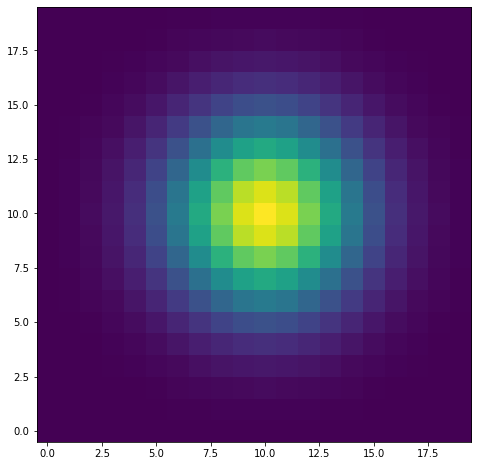

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(model,origin='lower')

As we can see, I now have a model for the PSF which I can easily create for given inputs. We're going to do this for cutouts around each star, and instead of a random $\sigma$, we're going to estimated it using the second moment (moment of inertia) of the star itself.

The formula for this (from Markevich et al. 1989) is 

$$
\sigma_x = \left[\frac{\sum x_i^2 \hat{f}_i}{\sum \hat{f}_i} - x_{\rm com}^2\right]^{1/2}
$$

$$
\sigma_y = \left[\frac{\sum y_i^2 \hat{f}_i}{\sum \hat{f}_i} - y_{\rm com}^2\right]^{1/2}
$$

In this case, we'll need to use `meshgrid()` directly within our second moment function, as you can see it depends on the difference between the pixels and the centroid.

In [494]:
def second_moment(image_cutout,xx,yy,centroid_x,centroid_y):
    '''
    Measure the second moment of the light distribution of star cutouts
    '''
    # Your code
    return sigma_x, sigma_y

Within 10%, this calculation, which requires no fitting, tells us $\sigma$ (under the assumption the distribution is Gaussian). Thus, by running out image cutouts through this function, we can derive for ourselves a good $\sigma$ to choose in our Gaussian model of the PSF. 

## Problem 5 

Last but not least, it's time to put eeeeeevvvvveeerrrryyyyttthhhiiiinnnggggg together. 

Let's sum up what we've done so far. In individual chunks and functions (albeit not in this order), we've 

1. Read in telescope imaging, along with dark and flat frames, and perform standard calibrations 
2. Used `sep` to estimate and subtract the spatially varying background 
3. Written a peak-finder which locates peaks in the image 
4. Gone through those peaks and removed hot pixels
5. Centroided the stars of those peaks and removed those which are associated with the same star 
6. Wrote code which can estimate the PSF from each star, and generate a gaussian model of it
7. Perform PSF photometry by multiplying the image flux by the PSF model

Right now, all this code is scattered throughout different cells and functions. Our one goal in this problem is to integrate these many steps into an easy to use **class** which automates this process, allowing for user input when necessary. 

Your goal is to write a single class, `PSFPhotometry`. It should have methods which handle the steps we've put together in this lab. 

One valuable aspect of the class format is that for information that's useful throughout the redution (like the peak and centroid lists), we can set these to be class `attributes`. This makes them accessible from anywhere in the class, and saves us the trouble of having to constantly return and read in these values.

Once you've created your pipeline, run our image through it and output a catalog of positions and fluxes. I've started off the basic structure of this class below.

In [ ]:
class PSFPhotometry():
    '''
    Docstring
    '''
    def __init__(self,...):
        '''
        Docstring
        '''
        pass
    def calibrate(self,...):
        '''
        Docstring
        '''
        pass
    def ... 